In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import random
import matplotlib.pyplot as plt
import os
import transformers
from collections import Counter
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch
from torch import cuda
from tqdm.notebook import tqdm
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from sklearn import metrics
from torchnlp.metrics import get_accuracy
import numpy as np

In [22]:
torch.set_printoptions(precision=10)
!pip install transformers
# SEEDS 
# [3,42,107,33,17]
seed = 33
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed)
# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed)
# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)
# 4. Set the `tensorflow` pseudo-random generator at a fixed value
torch.manual_seed(seed)

# [trec,clinc,r,ng]
dataset='trec'

In [3]:
!pip install transformers sentencepiece

# Data

In [4]:
path_data = '\\Users\\Camilo\\Desktop\\tesis\\codes\\data\\'
df = pd.read_csv(path_data+dataset+'Data.csv', delimiter='@')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5952 entries, 0 to 5951
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text_raw  5952 non-null   object
 1   label     5952 non-null   object
 2   group     5952 non-null   object
 3   text      5952 non-null   object
 4   class     5952 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 232.6+ KB


In [5]:
df.head()

,text_raw,label,group,text,class
0,manner How did serfdom develop in and then lea...,DESC,train,manner serfdom develop leav russia,1
1,manner How can I find a list of celebrities ' ...,DESC,train,manner find list celebr real name,1
2,def What are liver enzymes,DESC,val,def liver enzym,1
3,reason Why do heavier objects travel downhill ...,DESC,train,reason heavier object travel downhil faster,1
4,desc What did the only repealed amendment to t...,DESC,train,desc repeal amend us constitut deal,1


# Select pre-trained model

In [6]:
preTrainedModel = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(preTrainedModel)
bert_model = BertModel.from_pretrained(preTrainedModel,return_dict=False)

In [7]:
#Vamos a generar un CustomDataset (una formar de cargar datos en batches)
#Para pytorch, nos va a facilitar el entrenamiento
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.sentence = dataframe.text.values
        self.targets = self.data['class'].values
        self.max_len = max_len
    def __len__(self):
        return len(self.sentence)
    def __getitem__(self, index):
        sentence = str(self.sentence[index])
        sentence = " ".join(sentence.split())
        inputs = self.tokenizer.encode_plus(
            sentence,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            padding='max_length',
            truncation=True
        )
        ids = inputs['input_ids'] #Ids del vocabulario
        mask = inputs['attention_mask'] #Mascaras para definir donde la atencion deberia ver
        token_type_ids = inputs["token_type_ids"] #requerido pero no utilizado
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [8]:
#Generamos nuestra conexion a la GPU
device = 'cuda:0' if cuda.is_available() else 'cpu'
device

'cuda:0'

# Info for max len

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Camilo\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


33


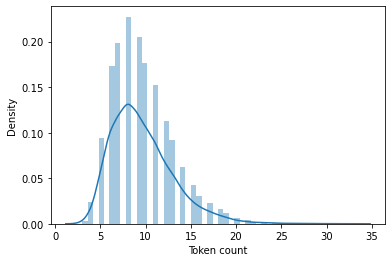

In [9]:
token_lens = []
for txt in df.text:
  toks = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(toks))

sns.distplot(token_lens)
print(np.max(token_lens))
plt.xlabel('Token count');

# Create Loader for data

In [10]:
# DataFrame to DataLoader
MAX_LEN = 20 # Len in function of dataset
training_set = CustomDataset(df[df.group == 'train'], tokenizer, MAX_LEN)
val_set = CustomDataset(df[df.group == 'val'], tokenizer, MAX_LEN)
test_set = CustomDataset(df[df.group == 'test'], tokenizer, MAX_LEN)

TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 16

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

# Dataloaders for pytorch

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(val_set, **test_params)
testing_loader = DataLoader(test_set, **test_params)

# Define Model, Loss function and Train

In [11]:
class BERTClass(torch.nn.Module):
    def __init__(self,b_model,k_classes,drop):
        super(BERTClass, self).__init__()
        self.l1 = b_model # Definimos que la primera capa sea el modelo de bert que recibe por parametro
        self.l2 = torch.nn.Dropout(drop) # A la salida de bert, vamos a aplicar un dropout de 0.1
        self.l3 = torch.nn.Linear(768,k_classes) #Finalmente vamos a definir una capa densa (combinación lineal) de la dimension de bert a nuestra neurona de salida
        #self.out_activation = torch.nn.Softmax(dim=1) #torch.nn.Sigmoid() # función de activación (que no vamos a utilizar)
        self.out_activation = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, ids, mask, token_type_ids):
        #Hacemos el forward pass por BERT, dropout y la capa densa
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids) 
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        output = self.out_activation(output)
        return output
    
# CrossEntropy
def loss_fn(outputs, targets):
    return torch.nn.CrossEntropyLoss()(outputs, targets)

def train(epoch,training_loader):
    model.train()
    loss_acum=0
    for iters , data in tqdm(enumerate(training_loader, 0), total = len(training_loader)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype=torch.long)
        outputs = model(ids, mask, token_type_ids)
        outputs = outputs.squeeze(1)
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss_acum += loss.item()
        #if iters%500==0:
            #print(outputs,targets)
            #print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('iters: ',iters)
    return loss_acum/iters

def validation(epoch,val_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(val_loader, 0),total = len(val_loader)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)

            targets = data['targets'].to(device, dtype=torch.long)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend((outputs).squeeze(1).cpu().detach().numpy())
    
    return np.array(fin_outputs), np.array(fin_targets)

# Training and Validation

In [23]:
#Generamos un modelo de BERTClass
EPOCHS = 5
k = len(df['class'].unique())
LRs = list()
DPs = list()
ACCs = list()
for dp in [0,0.1,0.3,0.5]:
    for lr in [1e-4,5e-05,1e-05]:
        dropOut = dp
        LEARNING_RATE = lr
        model = BERTClass(bert_model,k,dropOut)
        model.to(device)
        optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

        #iteramos por nuestras epocas
        print('Training')
        for epoch in range(EPOCHS):
            epoch_loss = train(epoch,training_loader)
            print(f'epoch loss: {epoch_loss}')

        print('Validation')
        for epoch in range(1):
            outputs, targets = validation(epoch,validation_loader)

        outs = list()
        for i in range(outputs.shape[0]):
            outs.append(np.where(outputs[i] == np.amax(outputs[i]))[0][0])

        accuracy, n_correct, n_total = get_accuracy(targets, outs)
        print('summary: ',lr,dp, accuracy)
        print('----------------------------------------------------------')
        LRs.append(lr)
        DPs.append(dp)
        ACCs.append(accuracy)


Training



iters:  544
epoch loss: 1.6719989919048899



iters:  544
epoch loss: 1.6650701748097645



iters:  544
epoch loss: 1.6637824848294258



iters:  544
epoch loss: 1.6639560743728106



iters:  544
epoch loss: 1.662145427263835
Validation



summary:  0.0001 0 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6722639862667112



iters:  544
epoch loss: 1.6592455412096836



iters:  544
epoch loss: 1.6597363786662327



iters:  544
epoch loss: 1.6600484216914457



iters:  544
epoch loss: 1.6593384609064634
Validation



summary:  5e-05 0 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.7066583736416172



iters:  544
epoch loss: 1.6584519088706549



iters:  544
epoch loss: 1.6571681898306398



iters:  544
epoch loss: 1.6571368351578712



iters:  544
epoch loss: 1.6565636911374682
Validation



summary:  1e-05 0 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6682602554997976



iters:  544
epoch loss: 1.6647710863719969



iters:  544
epoch loss: 1.6635017004959725



iters:  544
epoch loss: 1.668768645647694



iters:  544
epoch loss: 1.662521014976151
Validation



summary:  0.0001 0.1 0.22415370539798718
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6747095948633026



iters:  544
epoch loss: 1.6605428779388176



iters:  544
epoch loss: 1.6620310093550121



iters:  544
epoch loss: 1.66019213966587



iters:  544
epoch loss: 1.6608333221691496
Validation



summary:  5e-05 0.1 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.7024223819813307



iters:  544
epoch loss: 1.660217873094713



iters:  544
epoch loss: 1.6596010706442244



iters:  544
epoch loss: 1.6584286573616898



iters:  544
epoch loss: 1.6587908379733562
Validation



summary:  1e-05 0.1 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6715352226267843



iters:  544
epoch loss: 1.66736034369644



iters:  544
epoch loss: 1.6672620611155735



iters:  544
epoch loss: 1.6652262451894142



iters:  544
epoch loss: 1.6630675856243162
Validation



summary:  0.0001 0.3 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6768263514865847



iters:  544
epoch loss: 1.6612935589955133



iters:  544
epoch loss: 1.6615801955408909



iters:  544
epoch loss: 1.6617587020292002



iters:  544
epoch loss: 1.6625703273012358
Validation



summary:  5e-05 0.3 0.22872827081427263
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.702256883987609



iters:  544
epoch loss: 1.6669511738068916



iters:  544
epoch loss: 1.6597899636801552



iters:  544
epoch loss: 1.6614756833981066



iters:  544
epoch loss: 1.65871114371454
Validation



summary:  1e-05 0.3 0.22415370539798718
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6820352281279423



iters:  544
epoch loss: 1.6652365042006267



iters:  544
epoch loss: 1.6679282554370516



iters:  544
epoch loss: 1.6692076437175274



iters:  544
epoch loss: 1.6659526783315575
Validation



summary:  0.0001 0.5 0.2131747483989021
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.6739406114553703



iters:  544
epoch loss: 1.661526336827699



iters:  544
epoch loss: 1.6637277850771652



iters:  544
epoch loss: 1.6640906305435825



iters:  544
epoch loss: 1.6620266130741905
Validation



summary:  5e-05 0.5 0.22415370539798718
----------------------------------------------------------
Training



iters:  544
epoch loss: 1.7126962954507154



iters:  544
epoch loss: 1.6736090571126516



iters:  544
epoch loss: 1.667262324515511



iters:  544
epoch loss: 1.6628335118293762



iters:  544
epoch loss: 1.659618812667973
Validation



summary:  1e-05 0.5 0.22872827081427263
----------------------------------------------------------


In [24]:
df_acc = pd.DataFrame(list(zip(LRs, DPs,ACCs)), 
               columns =['lr', 'dp','acc']) 
df_acc 

,lr,dp,acc
0,0.00010,0.0,0.228728
1,0.00005,0.0,0.228728
2,0.00001,0.0,0.228728
3,0.00010,0.1,0.224154
4,0.00005,0.1,0.228728
5,0.00001,0.1,0.228728
6,0.00010,0.3,0.228728
7,0.00005,0.3,0.228728
8,0.00001,0.3,0.224154
9,0.00010,0.5,0.213175


In [25]:
df_acc.to_csv(path_or_buf=path_data+dataset+'Results-seed33-batch16.csv', sep='@',index=False)

# Info about errors

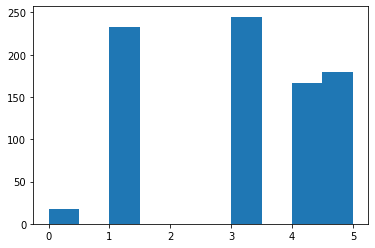

Most common class missclasiffied
class:  ['HUM']  errors:  245
class:  ['DESC']  errors:  233
class:  ['NUM']  errors:  180
class:  ['LOC']  errors:  167
class:  ['ABBR']  errors:  18
Most common pair of missclasiffied
class1:  ['HUM']  class2:  ['ENTY']  errors:  245
class1:  ['DESC']  class2:  ['ENTY']  errors:  233
class1:  ['NUM']  class2:  ['ENTY']  errors:  180
class1:  ['LOC']  class2:  ['ENTY']  errors:  167
class1:  ['ABBR']  class2:  ['ENTY']  errors:  18


In [14]:
def err_info(y,y_pred):
    targets = y
    outputs = y_pred
    sum = 0
    errs = list()
    pairs = list()
    for i in range(outputs.shape[0]):
        y_pred = np.where(outputs[i] == np.amax(outputs[i]))[0][0]
        y = targets[i]
        if (y == y_pred):
            sum += 1.
        else:
            errs.append(y)
            pairs.append((y,y_pred))
    plt.hist(errs)
    plt.show()

    encoder = LabelEncoder()
    encoder.classes_ = np.load(path_data+dataset+'-classesEncoder.npy',allow_pickle=True)

    print('Most common class missclasiffied')
    for c,v in Counter(errs).most_common():
        print('class: ',encoder.inverse_transform([c]),' errors: ',v)

    print('Most common pair of missclasiffied')
    for t,v in Counter(pairs).most_common():
        c1,c2 = t
        print('class1: ',encoder.inverse_transform([c1]),' class2: ',encoder.inverse_transform([c2]) ,' errors: ',v)
        
err_info(targets,outputs)